In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

In [3]:
class SMSSpamClassifier:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        self.model = LogisticRegression(random_state=42, max_iter=1000)
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        
    def load_data(self, file_path):
        """
        Load SMS dataset from CSV file
        Expected format: columns ['label', 'message'] or ['v1', 'v2']
        """
        try:
            # Try different common formats for SMS spam datasets
            df = pd.read_csv(file_path, encoding='latin-1')
            
            # Handle different column naming conventions
            if 'v1' in df.columns and 'v2' in df.columns:
                df = df[['v1', 'v2']].copy()
                df.columns = ['label', 'message']
            elif 'Label' in df.columns and 'SMS' in df.columns:
                df = df[['Label', 'SMS']].copy()
                df.columns = ['label', 'message']
            
            # Convert labels to binary (0 for ham, 1 for spam)
            df['label'] = df['label'].map({'ham': 0, 'spam': 1})
            
            print(f"Dataset loaded successfully!")
            print(f"Shape: {df.shape}")
            print(f"Label distribution:\n{df['label'].value_counts()}")
            
            return df
            
        except Exception as e:
            print(f"Error loading data: {e}")
            # Create sample data for demonstration
            return self.create_sample_data()
    
    def create_sample_data(self):
        """Create sample SMS data for demonstration purposes"""
        sample_data = {
            'label': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1] * 50,
            'message': [
                "Hey, how are you doing today?",
                "URGENT! You've won $1000! Click here now!",
                "Can you pick up milk on your way home?",
                "FREE! Call now to claim your prize!",
                "Meeting at 3pm in conference room",
                "CONGRATULATIONS! You're our lucky winner!",
                "Thanks for the help yesterday",
                "Limited time offer! Act now!",
                "See you at dinner tonight",
                "CASH PRIZE waiting for you!"
            ] * 50
        }
        df = pd.DataFrame(sample_data)
        print("Using sample data for demonstration")
        return df
    
    def preprocess_text(self, text):
        """
        Preprocess text data by cleaning and normalizing
        """
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove phone numbers
        text = re.sub(r'\b\d{10,}\b', '', text)
        
        # Remove punctuation and special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        # Remove stopwords and apply stemming
        words = text.split()
        words = [self.stemmer.stem(word) for word in words if word not in self.stop_words]
        
        return ' '.join(words)
    
    def explore_data(self, df):
        """
        Perform exploratory data analysis
        """
        print("\n=== DATA EXPLORATION ===")
        print(f"Dataset shape: {df.shape}")
        print(f"\nMissing values:\n{df.isnull().sum()}")
        print(f"\nLabel distribution:")
        print(df['label'].value_counts())
        print(f"\nLabel percentages:")
        print(df['label'].value_counts(normalize=True) * 100)
        
        # Message length analysis
        df['message_length'] = df['message'].str.len()
        df['word_count'] = df['message'].str.split().str.len()
        
        print(f"\nMessage length statistics:")
        print(df.groupby('label')['message_length'].describe())
        
        # Visualization
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        df['label'].value_counts().plot(kind='bar')
        plt.title('Distribution of Labels')
        plt.xlabel('Label (0=Ham, 1=Spam)')
        plt.ylabel('Count')
        
        plt.subplot(1, 3, 2)
        df.boxplot(column='message_length', by='label', ax=plt.gca())
        plt.title('Message Length by Label')
        plt.suptitle('')
        
        plt.subplot(1, 3, 3)
        df.boxplot(column='word_count', by='label', ax=plt.gca())
        plt.title('Word Count by Label')
        plt.suptitle('')
        
        plt.tight_layout()
        plt.show()
        
        return df
    
    def prepare_features(self, df):
        """
        Prepare features using TF-IDF vectorization
        """
        print("\n=== FEATURE PREPARATION ===")
        
        # Preprocess messages
        print("Preprocessing text data...")
        df['processed_message'] = df['message'].apply(self.preprocess_text)
        
        # Apply TF-IDF vectorization
        print("Applying TF-IDF vectorization...")
        X = self.vectorizer.fit_transform(df['processed_message'])
        y = df['label']
        
        print(f"Feature matrix shape: {X.shape}")
        print(f"Number of features: {X.shape[1]}")
        
        return X, y
    
    def train_model(self, X_train, y_train):
        """
        Train the Logistic Regression model
        """
        print("\n=== MODEL TRAINING ===")
        print("Training Logistic Regression model...")
        
        self.model.fit(X_train, y_train)
        print("Model training completed!")
        
        return self.model
    
    def evaluate_model(self, X_test, y_test):
        """
        Evaluate the model and display metrics
        """
        print("\n=== MODEL EVALUATION ===")
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        
        # Detailed classification report
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
    
    def get_feature_importance(self, top_n=20):
        """
        Display most important features for spam classification
        """
        print(f"\n=== TOP {top_n} FEATURES FOR SPAM CLASSIFICATION ===")
        
        # Get feature names and coefficients
        feature_names = self.vectorizer.get_feature_names_out()
        coefficients = self.model.coef_[0]
        
        # Create feature importance dataframe
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients
        })
        
        # Sort by absolute coefficient value
        feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
        feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
        
        print("Most important features (positive = spam indicators):")
        print(feature_importance.head(top_n)[['feature', 'coefficient']])
        
        # Visualization
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(top_n)
        colors = ['red' if coef > 0 else 'blue' for coef in top_features['coefficient']]
        
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Top {top_n} Most Important Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    def predict_message(self, message):
        """
        Predict if a single message is spam or ham
        """
        processed_message = self.preprocess_text(message)
        message_vector = self.vectorizer.transform([processed_message])
        prediction = self.model.predict(message_vector)[0]
        probability = self.model.predict_proba(message_vector)[0]
        
        result = "SPAM" if prediction == 1 else "HAM"
        confidence = max(probability)
        
        print(f"\nMessage: '{message}'")
        print(f"Prediction: {result}")
        print(f"Confidence: {confidence:.4f}")
        
        return prediction, confidence

In [4]:
# Create an instance of the SMS Spam Classifier
classifier = SMSSpamClassifier()
print("SMS Spam Classifier initialized successfully!")

SMS Spam Classifier initialized successfully!


In [9]:
# Load data (replace 'sms_spam_dataset.csv' with your actual dataset path)
# If you don't have a dataset, this will create sample data for demonstration
df = classifier.load_data(r"C:\Users\Yaswa\OneDrive\Desktop\spam\spam.csv")

Dataset loaded successfully!
Shape: (5572, 2)
Label distribution:
label
0    4825
1     747
Name: count, dtype: int64



=== DATA EXPLORATION ===
Dataset shape: (5572, 2)

Missing values:
label      0
message    0
dtype: int64

Label distribution:
label
0    4825
1     747
Name: count, dtype: int64

Label percentages:
label
0    86.593683
1    13.406317
Name: proportion, dtype: float64

Message length statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
0      4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
1       747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


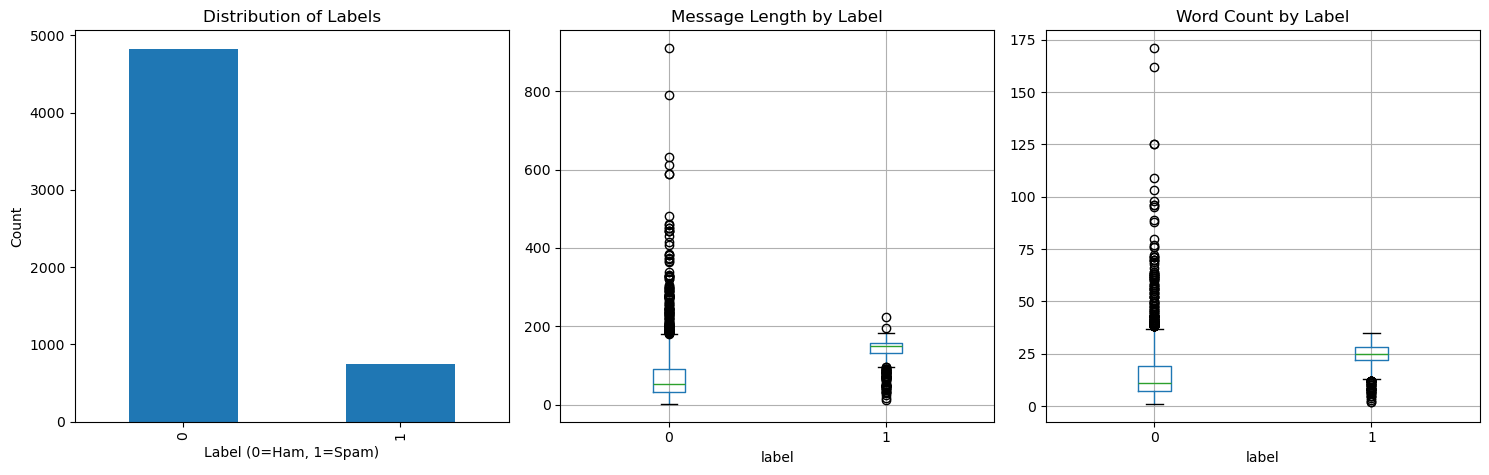

In [10]:
# Perform exploratory data analysis
df = classifier.explore_data(df)

In [12]:
# Prepare features using TF-IDF vectorization
X, y = classifier.prepare_features(df)


=== FEATURE PREPARATION ===
Preprocessing text data...
Applying TF-IDF vectorization...
Feature matrix shape: (5572, 5000)
Number of features: 5000


In [13]:
# Split data into training and testing sets
print("=== DATA SPLITTING ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

=== DATA SPLITTING ===
Training set size: 4457
Test set size: 1115


In [14]:
# Train the Logistic Regression model
classifier.train_model(X_train, y_train)


=== MODEL TRAINING ===
Training Logistic Regression model...
Model training completed!


LogisticRegression(max_iter=1000, random_state=42)


=== MODEL EVALUATION ===
Accuracy: 0.9552
Precision: 0.9901
Recall: 0.6711
F1-Score: 0.8000

Detailed Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       966
        Spam       0.99      0.67      0.80       149

    accuracy                           0.96      1115
   macro avg       0.97      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115



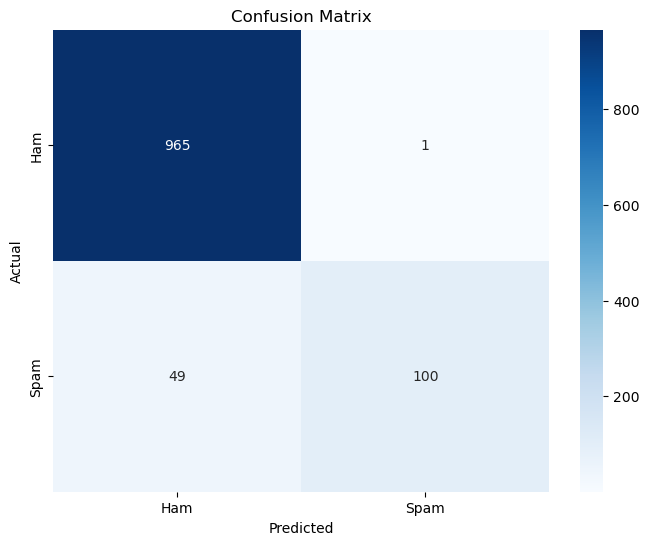

In [15]:
# Evaluate the model and display metrics
results = classifier.evaluate_model(X_test, y_test)


=== TOP 20 FEATURES FOR SPAM CLASSIFICATION ===
Most important features (positive = spam indicators):
      feature  coefficient
4329      txt     5.250263
499     claim     4.048585
3287   servic     3.497132
3004    repli     3.384189
1456     free     3.379247
2302    mobil     3.259720
3741     stop     3.233199
2744    prize     3.041345
4021     text     2.846668
4437   urgent     2.646769
4734      win     2.617831
192     award     2.414967
4203     tone     2.301321
578   contact     2.286527
2421    nokia     2.240285
466      chat     2.149727
2401      new     2.117144
2162     ltgt    -2.083291
3964       tc     2.068373
529   collect     2.046128


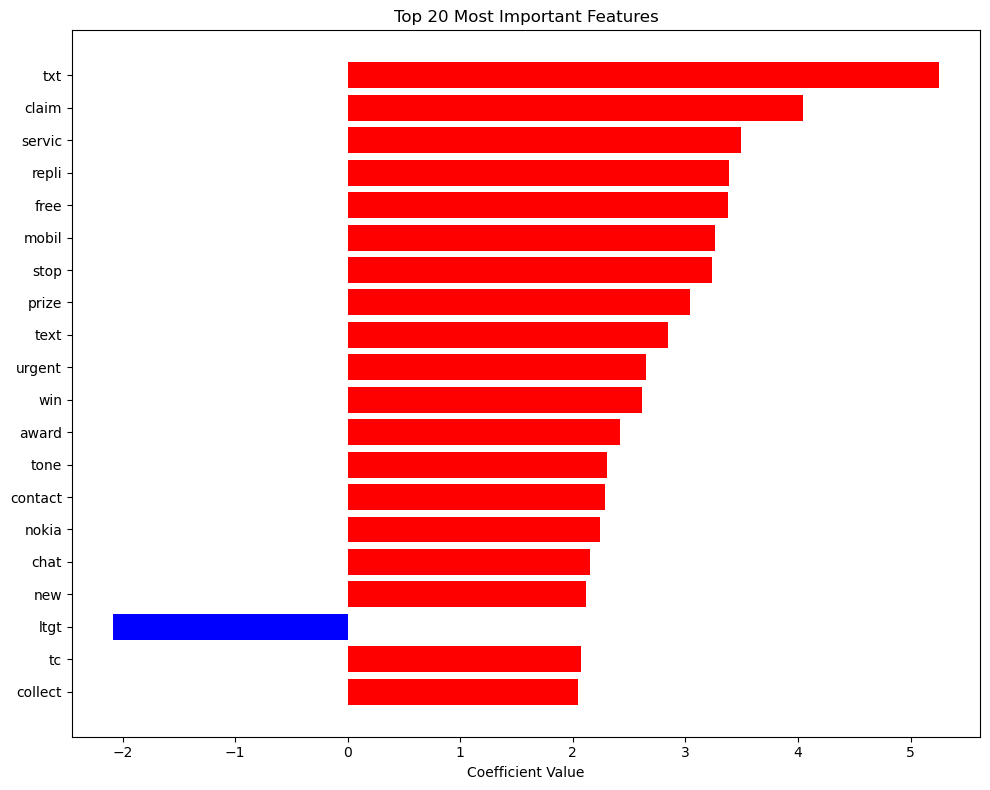

In [16]:
# Display the most important features for spam classification
classifier.get_feature_importance(top_n=20)

In [17]:
# Test the classifier with sample messages
print("=== TESTING WITH SAMPLE MESSAGES ===")

test_messages = [
    "Hey, are we still meeting for lunch today?",
    "URGENT! You've won $10,000! Click here to claim now!",
    "Can you send me the report by tomorrow?",
    "FREE! Limited time offer! Call now!",
    "Thanks for your help with the project"
]

for message in test_messages:
    classifier.predict_message(message)

=== TESTING WITH SAMPLE MESSAGES ===

Message: 'Hey, are we still meeting for lunch today?'
Prediction: HAM
Confidence: 0.9755

Message: 'URGENT! You've won $10,000! Click here to claim now!'
Prediction: SPAM
Confidence: 0.6366

Message: 'Can you send me the report by tomorrow?'
Prediction: HAM
Confidence: 0.9186

Message: 'FREE! Limited time offer! Call now!'
Prediction: HAM
Confidence: 0.7153

Message: 'Thanks for your help with the project'
Prediction: HAM
Confidence: 0.8949


In [18]:
# Interactive testing - you can modify this message and run the cell
custom_message = "Congratulations! You have won a free iPhone! Click the link to claim your prize now!"
classifier.predict_message(custom_message)


Message: 'Congratulations! You have won a free iPhone! Click the link to claim your prize now!'
Prediction: SPAM
Confidence: 0.8619


(1, 0.8618567460354111)